In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import glob
import cv2
import time

import torchvision
import torch
from torchvision.models import vgg16
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels - 1):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

def laplacian_pyramid(gaussian_pyramid):
    pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        upsampled = cv2.pyrUp(gaussian_pyramid[i + 1])
        laplacian = cv2.subtract(gaussian_pyramid[i], upsampled)
        pyramid.append(laplacian)
    pyramid.append(gaussian_pyramid[-1])
    return pyramid



#       Create Train, Valid and Test sets
Please put *Linnaeus 5 256X256* folder under your google drive directory

Reference: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [ ]:
train_data_path = './drive/My Drive/Linnaeus 5 256X256/train'
test_data_path = './drive/My Drive/Linnaeus 5 256X256//test'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

# 1. get all the paths from train_data_path and append image paths and class to to respective lists
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

# 2. split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

# 3. create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  ./drive/My Drive/Linnaeus 5 256X256/train/other/364_256.jpg
class example:  other
Train size: 4800
Valid size: 1200
Test size: 2000


In [ ]:
# Create dictionary for class indexes
class_to_idx = {'berry': 0, 'bird': 1, 'dog': 2, 'flower': 3, 'other': 4}

# Load Dataset
Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
from torch.utils.data import Dataset
class Linnaeus5Dataset(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

transform = torchvision.transforms.ToTensor()
train_data = Linnaeus5Dataset(train_image_paths, transform=transform)
valid_data = Linnaeus5Dataset(valid_image_paths, transform=transform)
test_data = Linnaeus5Dataset(test_image_paths, transform=transform)



In [ ]:
from torch.utils.data import Dataset
class Linnaeus5Dataset(Dataset):
    def __init__(self, image_paths, transform=None, target_transform=None, pyramid_levels=3):
        self.image_paths = image_paths
        self.transform = transform
        self.target_transform = target_transform
        self.pyramid_levels = pyramid_levels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Laplacian Pyramid
        g_pyr = gaussian_pyramid(image, self.pyramid_levels)
        l_pyr = laplacian_pyramid(g_pyr)

        # Get level 0 Laplacian Pyramid image
        level_0_image = l_pyr[0]

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            level_0_image = self.transform(level_0_image)
        if self.target_transform:
            label = self.target_transform(label)

        return level_0_image, label

# Define the data transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor()
])

# Create the datasets with Laplacian Pyramid (3 levels)
train_data = Linnaeus5Dataset(train_image_paths, transform=transform, pyramid_levels=3)
valid_data = Linnaeus5Dataset(valid_image_paths, transform=transform, pyramid_levels=3)
test_data = Linnaeus5Dataset(test_image_paths, transform=transform, pyramid_levels=3)


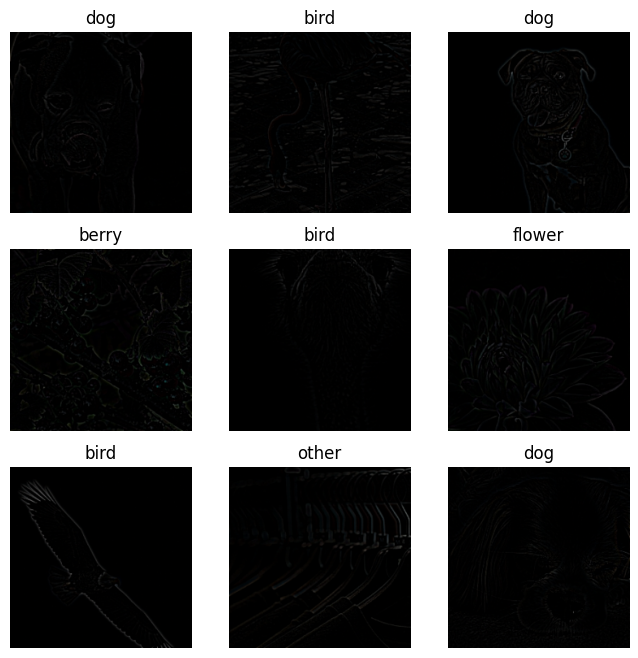

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  1


In [ ]:
# Show some example images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    title = [j for j in class_to_idx if class_to_idx[j]==label][0]
    plt.title(title)
    plt.axis("off")
    plt.imshow(img.numpy().transpose((1,2,0))) # Need to transpose the matrix before plot
plt.show()

print('The shape of tensor for 50th image in train dataset: ',train_data[49][0].shape)
print('The label for 50th image in train dataset: ',train_data[49][1])


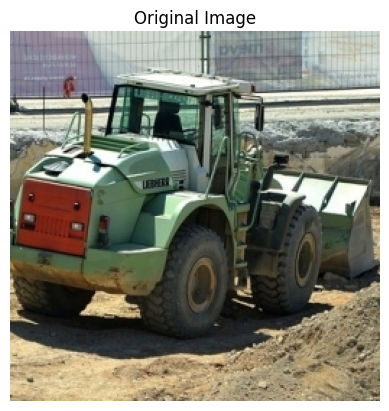

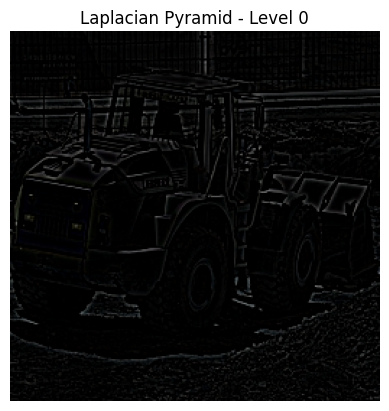

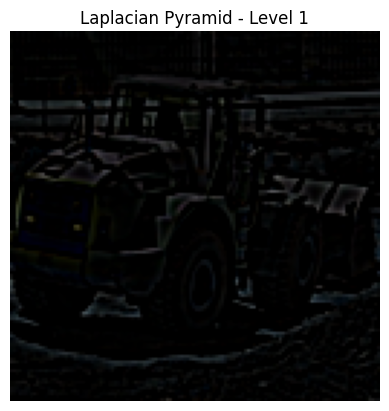

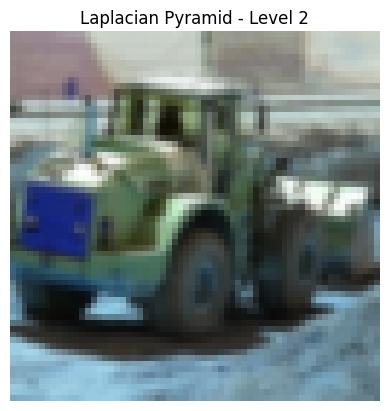

In [ ]:
def display_pyramid(pyramid, title):
    for i, img in enumerate(pyramid):
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title(f"{title} - Level {i}")
        plt.axis('off')
        plt.show()


# Get an example image and label from the dataset
example_image, example_label = train_data[0]

# Load the original image
example_image_filepath = train_image_paths[0]
original_image = cv2.imread(example_image_filepath)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply Gaussian Pyramid
g_pyr = gaussian_pyramid(original_image,3)

# Apply Laplacian Pyramid
l_pyr = laplacian_pyramid(g_pyr)

# Display original image
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Display Laplacian Pyramid images
display_pyramid(l_pyr, "Laplacian Pyramid")


In [ ]:
train_data_size = len(train_data)
valid_data_size = len(valid_data)
test_data_size = len(test_data)

train_dataloader = DataLoader(train_data, batch_size=64)
valid_dataloader = DataLoader(valid_data, batch_size=64)

# Instantiate a pre-trained VGG16 model
network = vgg16(pretrained=True)

# Add an adaptive average pooling layer before the classifier
network.avgpool = nn.AdaptiveAvgPool2d((7, 7))

# Replace the final layer with a new linear layer for 5 classes
num_classes = 5
network.classifier[6] = nn.Linear(4096, num_classes)


if torch.cuda.is_available():
    network = network.cuda()

loss_fn = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()

learning_rate = 1e-2
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)


epoch = 30

train_losses = []
valid_losses = []
valid_accuracies = []

start_time = time.time()

for i in range(epoch):
    print("------Epoch-{}------".format(i+1))

    # Train
    network.train()
    cumulative_train_loss = 0
    total_samples = 0
    for data in train_dataloader:
        imgs, targets = data
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            targets = targets.cuda()
        outputs = network(imgs)
        loss = loss_fn(outputs, targets)

        # Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update cumulative_train_loss and total_samples
        cumulative_train_loss += loss.item() * imgs.size(0)
        total_samples += imgs.size(0)

    # Calculate average training loss
    average_train_loss = cumulative_train_loss / total_samples
    print("Train Loss: {}".format(average_train_loss))
    train_losses.append(average_train_loss)

    # Valid
    network.eval()
    cumulative_valid_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for data in valid_dataloader:
            imgs, targets = data
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                targets = targets.cuda()
            outputs = network(imgs)
            loss = loss_fn(outputs, targets)
            cumulative_valid_loss += loss.item() * imgs.size(0)
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy += accuracy

    average_valid_loss = cumulative_valid_loss / valid_data_size
    valid_accuracy = total_accuracy.item() / valid_data_size

    print("Valid Loss: {}".format(average_valid_loss))
    print("Valid Accuracy: {}".format(valid_accuracy))

    valid_losses.append(average_valid_loss)
    valid_accuracies.append(valid_accuracy)


elapsed_time = time.time() - start_time
print("Total training time: {:.2f} seconds".format(elapsed_time))
torch.save(network, "/content/drive/MyDrive/network_VGG.pth")
print("OK")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


------Epoch-1------
Train Loss: 0.9517837421099344
Valid Loss: 0.4172626805305481
Valid Accuracy: 0.8466666666666667
------Epoch-2------
Train Loss: 0.35654316544532777
Valid Loss: 0.3835205547014872
Valid Accuracy: 0.8616666666666667
------Epoch-3------
Train Loss: 0.35748840471108756
Valid Loss: 0.25527790864308675
Valid Accuracy: 0.9025
------Epoch-4------
Train Loss: 0.1886594957113266
Valid Loss: 0.2574689074357351
Valid Accuracy: 0.9
------Epoch-5------
Train Loss: 0.14384395711123943
Valid Loss: 0.1765420244137446
Valid Accuracy: 0.9325
------Epoch-6------
Train Loss: 0.12055740274488926
Valid Loss: 0.18226525485515593
Valid Accuracy: 0.9341666666666667
------Epoch-7------
Train Loss: 1.2625196435054142
Valid Loss: 1.6097548468907674
Valid Accuracy: 0.1975
------Epoch-8------
Train Loss: 1.5985828987757364
Valid Loss: 1.5389216089248656
Valid Accuracy: 0.33666666666666667
------Epoch-9------
Train Loss: 0.4088247389594714
Valid Loss: 0.1977773920694987
Valid Accuracy: 0.93416666

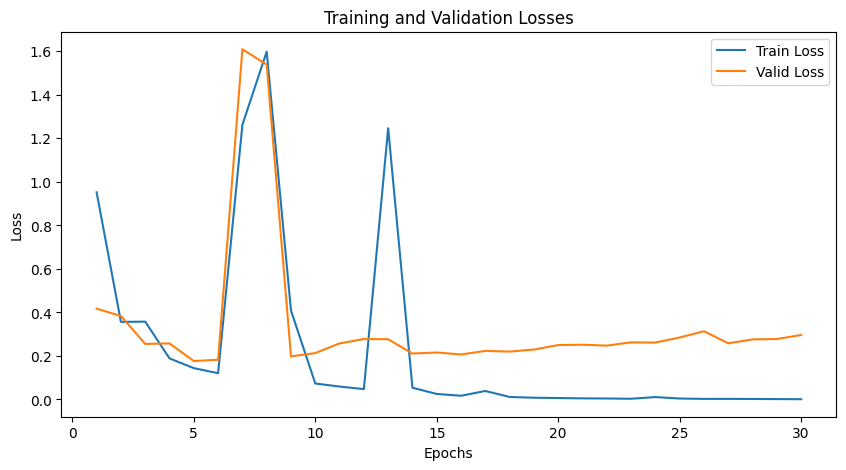

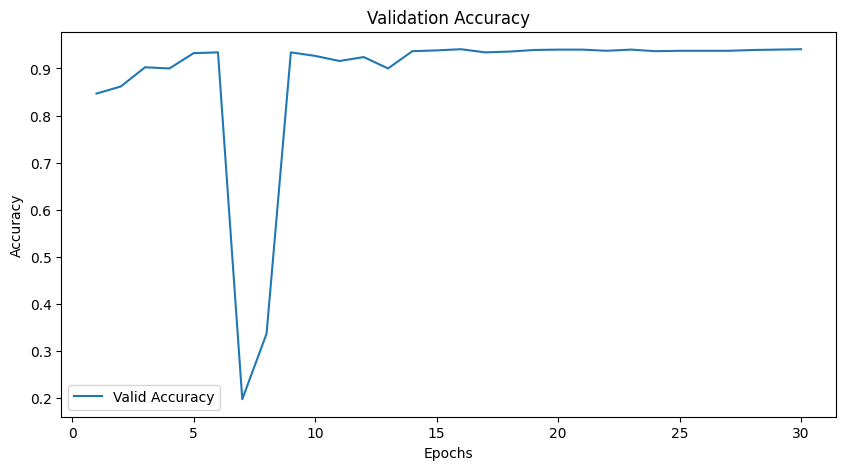

In [ ]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), train_losses, label='Train Loss')
plt.plot(range(1, epoch+1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch+1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
!nvidia-smi

Tue May  2 03:23:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |  14157MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------